<a href="https://colab.research.google.com/github/rajashekar028/TopicModellingOnNewsArticles/blob/main/Copy_of_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
!pip install autocorrect
!pip install pyLDAvis
!pip install unidecode
!pip install umap
!pip install --upgrade pandas==1.2

Requirement already up-to-date: pandas==1.2 in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [ ]:


# importing required libraries
import pandas as pd
import numpy as np
import string
import os
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import unidecode
import itertools
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import umap



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing dataset
news=[]
topics=[]

path="/content/drive/MyDrive/bbc/"
folders=['business','entertainment','politics','sport','tech'] 

for i in folders:
    all_files=os.listdir(path+i)
    for txt_files in all_files:
        files_path=path+i+'/'+txt_files
        with open(files_path,'rb') as f:
            text=f.read()
        news.append(text)
        topics.append(i)

bbc = {'news':news,'topics':topics}
bbc = pd.DataFrame(bbc)

In [ ]:
# checking dataset
print(bbc.head())

                                                news    topics
0  b'Yukos unit buyer faces loan claim\n\nThe own...  business
1  b'Ad sales boost Time Warner profit\n\nQuarter...  business
2  b'Dollar gains on Greenspan speech\n\nThe doll...  business
3  b'US trade gap hits record in 2004\n\nThe gap ...  business
4  b'High fuel prices hit BA\'s profits\n\nBritis...  business


In [ ]:
bbc.shape

(2225, 2)

In [ ]:
bbc.news[0]

b'Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (\xc2\xa3479m) loan.\n\nState-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit."\n\nRosneft o

In [ ]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   topics  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
print(bbc.describe(include='all').T)

       count unique                                                top freq
news    2225   2127  b'Sony PSP console hits US in March\n\nUS game...    2
topics  2225      5                                              sport  511


In [ ]:
len(bbc[bbc.duplicated()])

98

In [ ]:
bbc=bbc.drop_duplicates(ignore_index=True)

In [ ]:
# new dataset size
bbc.shape

(2127, 2)

In [ ]:
bbc.topics.value_counts()

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: topics, dtype: int64

In [ ]:
# percentage count of 'topics'
bbc.topics.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: topics, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


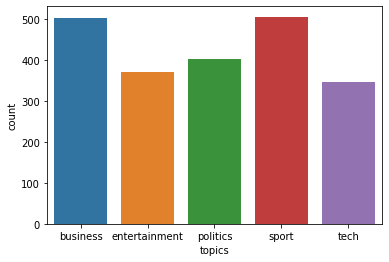

In [ ]:
sns.countplot(bbc['topics'], data=bbc)
plt.show()

In [ ]:
bbc1=bbc.copy()

In [ ]:
bbc1['news'] = bbc1['news'].astype('str')

In [ ]:
bbc1.news[0]

'b\'Yukos unit buyer faces loan claim\\n\\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (\\xc2\\xa3479m) loan.\\n\\nState-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\\\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\\\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\\\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit.

In [ ]:
len(bbc1.news[0])

1571

# text pre-processing

In [ ]:
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [ ]:
bbc1['news'] = bbc1['news'].apply(remove_html_tags)

In [ ]:
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [ ]:
bbc1['news'] = bbc1['news'].apply(remove_urls)

In [ ]:
bbc1.news[0]

'b\'Yukos unit buyer faces loan claim\\n\\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (\\xc2\\xa3479m) loan.\\n\\nState-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\\\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\\\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\\\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit.

In [ ]:
# replacing every non-word characters with a white space
for i in range(len(bbc1.news)):      
  bbc1.news[i] = re.sub(r"b\'", " ", bbc1.news[i]) 
  bbc1.news[i] = re.sub(r"\\\'", " ", bbc1.news[i])    
  bbc1.news[i] = re.sub(r"\\n\\n", " ", bbc1.news[i]) 
  bbc1.news[i] = re.sub(r"\\\'s", " ", bbc1.news[i])
  bbc1.news[i] = re.sub(r"(\\xc2\\xa3479m)", " ", bbc1.news[i])

In [ ]:
bbc1.news[0]

' Yukos unit buyer faces loan claim The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m ( ) loan. State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos  owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit." Rosneft officials were unavailab

In [ ]:
# Convert accented characters to ASCII characters
def accented_to_ascii(text):
	text = unidecode.unidecode(text)
	return text

In [ ]:
bbc1['news'] = bbc1['news'].apply(accented_to_ascii)

In [ ]:
# remove punctuations
def remove_punctuation(text):    
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [ ]:
bbc1['news'] = bbc1['news'].apply(remove_punctuation)

In [ ]:
# Remove numbers
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [ ]:
bbc1['news'] = bbc1['news'].apply(remove_numbers)

In [ ]:
# Lowercase all texts
def lower_case_convertion(text):
	lower_text = text.lower()
	return lower_text

In [ ]:
bbc1['news'] = bbc1['news'].apply(lower_case_convertion)

In [ ]:
# Split attached words
def split_word(text):
  split = re.split("([A-Z][a-z]+[^A-Z]*)",text)
  return " ".join(split)

In [ ]:
bbc1['news'] = bbc1['news'].apply(split_word)

In [ ]:
# Removing short length words
bbc1['news'] = bbc1['news'].apply(lambda x: ' '.join([wds for wds in x.split() if len(wds)>1]))

In [ ]:
# Remove extra whitespaces


def remove_extra_spaces(text):
	space_pattern = r'\s+'
	without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
	return without_space

bbc1['news'] = bbc1['news'].apply(remove_extra_spaces)

In [ ]:
# Standardizing and Spelling correction
def correction(text):
  standz = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) 
  spell = Speller(lang='en') 
  correct_spell=spell(standz) 
  return correct_spell

In [ ]:
bbc1['news'] = bbc1['news'].apply(correction)

In [ ]:
bbc1.news[0]

'euros unit buyer faces loan claim the owners of embattled russian oil giant euros are to ask the buyer of its former production unit to pay back loan stationed rosneft bought the yugansk unit for bn in sale forced by russia to part settle bn tax claim against euros euros owner senate group says it will ask rosneft to repay loan that yugansk had secured on its assets rosneft already faces similar repayment demand from foreign banks legal experts said rosneft purchase of yugansk would include such obligations the pledged assets are with rosneft so it will have to pay real money to the creditors to avoid seizure of yugansk assets said moscowbased us lawyer jamie limestone who is not connected to the case senate group managing director tim osborne told the reuters news agency if they default we will fight them where the rule of law exists under the international arbitration clauses of the credit rosneft officials were unavailable for comment but the company has said it intends to take act

In [ ]:
len(bbc1.news[0])

1472

In [ ]:
# Lemmatization
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text): 
	lemmas = [lemmatizer.lemmatize(wds, pos ='v') for wds in text.split()] 
	return " ".join(lemmas)

In [ ]:
bbc1['news'] = bbc1['news'].apply(lemmatize_word)

In [ ]:
# remove stopwords
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)
# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):  
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

In [ ]:
bbc1['news'] = bbc1['news'].apply(stop_words)

In [ ]:
len(bbc1.news[0])

998

In [ ]:
# remove frequent words


In [ ]:


# list of frequent words
freq = pd.Series(' '.join(bbc1['news']).split()).value_counts()[:15]
freq



mr            3005
people        2046
new           1971
year          1828
game          1665
use           1529
win           1507
time          1480
xa            1402
xc            1398
come          1217
play          1201
world         1166
government    1149
film          1144
dtype: int64

In [ ]:
# creating list of non-useful frequent words to remove from corpus
freq_words = ['mr','xa','xc','use','come','tell','year','month','time']

In [ ]:


# removing non-useful frequent words
bbc1['news'] = bbc1['news'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_words))



In [ ]:
# list of new frequent words in dataset
freq_new = pd.Series(' '.join(bbc1['news']).split()).value_counts()[:15]

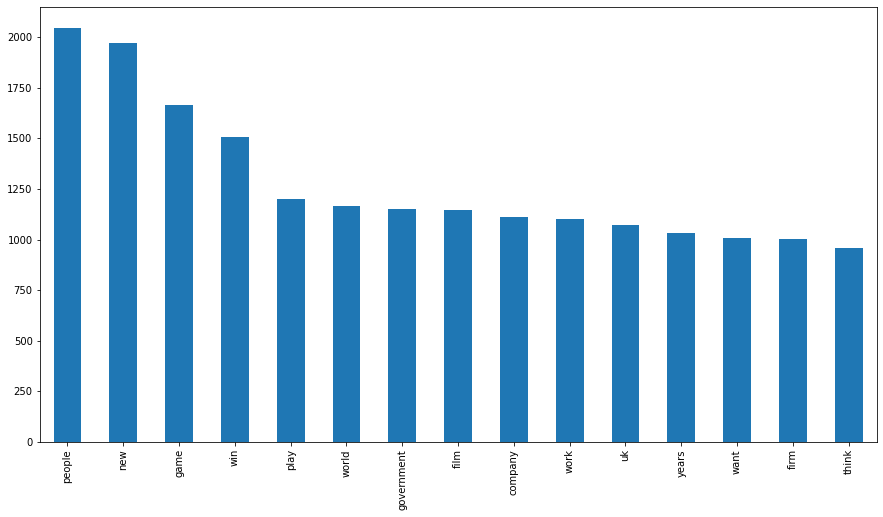

In [ ]:
# bar plot of frequent words
plt.figure(figsize=(15,8))
freq_new.plot.bar()
plt.show()

In [ ]:
# post cleaning first observation
bbc1.news[0]

'euros unit buyer face loan claim owners embattle russian oil giant euros ask buyer production unit pay loan station rosneft buy yugansk unit bn sale force russia settle bn tax claim euros euros owner senate group ask rosneft repay loan yugansk secure assets rosneft face similar repayment demand foreign bank legal experts rosneft purchase yugansk include obligations pledge assets rosneft pay real money creditors avoid seizure yugansk assets moscowbased lawyer jamie limestone connect case senate group manage director tim osborne reuters news agency default fight rule law exist international arbitration clauses credit rosneft officials unavailable comment company intend action senate recover tax claim debts owe yugansk euros file bankruptcy protection court attempt prevent force sale main production arm sale ahead december yugansk sell littleknown shell company turn buy rosneft euros claim downfall punishment political ambition founder michael khodorkovsky vow sue participant sales'

In [ ]:
len(bbc1.news[0])

993


# feature extraction

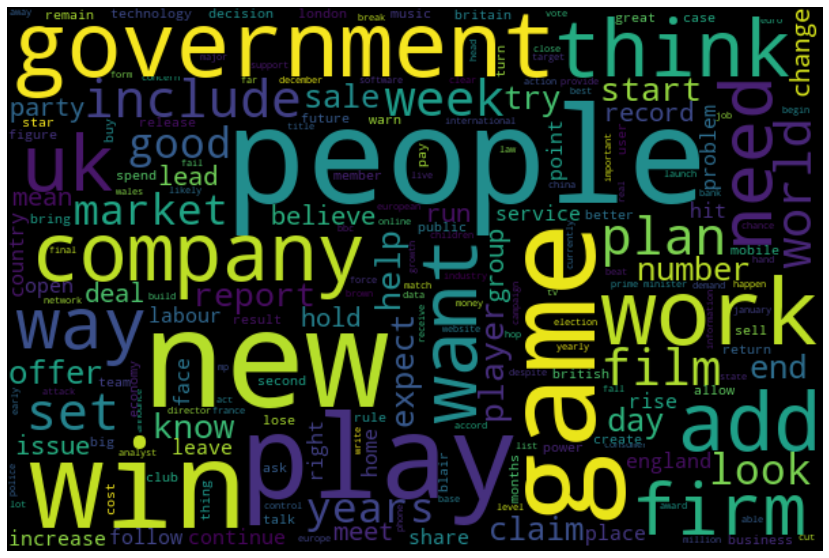

In [ ]:
# wordcloud of all topics
plt.figure(figsize=(15,10))
allWords = ' '.join(bbc1['news'])
wordCloud = WordCloud(width=600, height=400, random_state=0, max_font_size=100).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# now we will check for each topic what are the most frequent words, so that we can compare those words with our model generated 5 cluster/topics

In [ ]:
# frequent words for each topic
for i in bbc1.topics.unique():
  print(i)
  print('\n')
  print(pd.Series(' '.join(bbc1[bbc1['topics']==i]['news']).split()).value_counts()[:10])
  print('\n')

business


bn         775
company    627
firm       555
market     543
bank       459
rise       452
new        416
share      402
price      394
growth     384
dtype: int64


entertainment


film       965
best       591
award      522
star       437
music      435
win        386
include    332
new        322
years      246
band       243
dtype: int64


politics


labour        765
government    727
party         711
people        623
blair         574
minister      567
election      565
plan          487
new           430
brown         384
dtype: int64


sport


win        831
game       663
play       624
england    460
world      378
match      332
second     312
players    308
team       307
cup        292
dtype: int64


tech


people        960
game          878
phone         542
new           517
service       512
technology    504
mobile        493
users         409
firm          391
music         385
dtype: int64




In [ ]:
# creating some new variables to analyze the data in detail

In [ ]:
# length of articles

In [ ]:
# creating 'length' column
bbc1['length']=bbc1['news'].apply(len)
print(bbc1.head())

                                                news    topics  length
0  euros unit buyer face loan claim owners embatt...  business     993
1  ad sales boost warner profit quarterly profit ...  business    1554
2  dollar gain greenspan speech dollar hit highes...  business    1326
3  trade gap hit record gap export import hit all...  business    1111
4  high fuel price hit ba profit british airways ...  business    1423


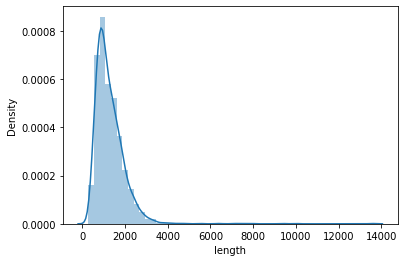

In [ ]:
# distplot of 'length'
sns.distplot(bbc1['length'])
plt.show()

In [ ]:
# most of the articles are of 0-4000 length

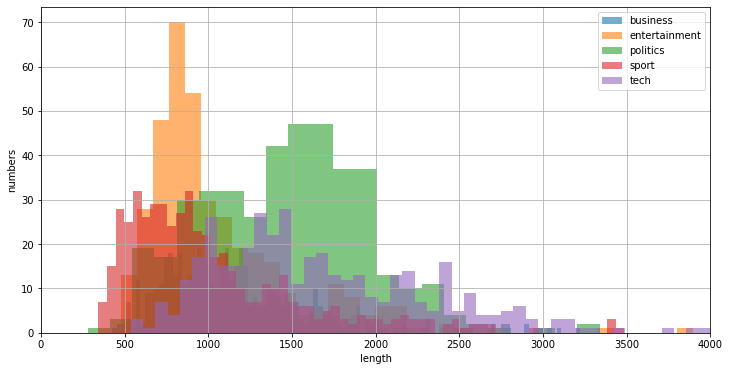

In [ ]:
# histogram of all topic's length
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,4000)
plt.grid()
plt.show()


In [ ]:
# number of words

In [ ]:
# creating 'word_count' column
bbc1['word_count'] = bbc1['news'].apply(lambda x: len(str(x).split(" ")))
print(bbc1.head())

                                                news  ... word_count
0  euros unit buyer face loan claim owners embatt...  ...        142
1  ad sales boost warner profit quarterly profit ...  ...        213
2  dollar gain greenspan speech dollar hit highes...  ...        187
3  trade gap hit record gap export import hit all...  ...        154
4  high fuel price hit ba profit british airways ...  ...        202

[5 rows x 4 columns]


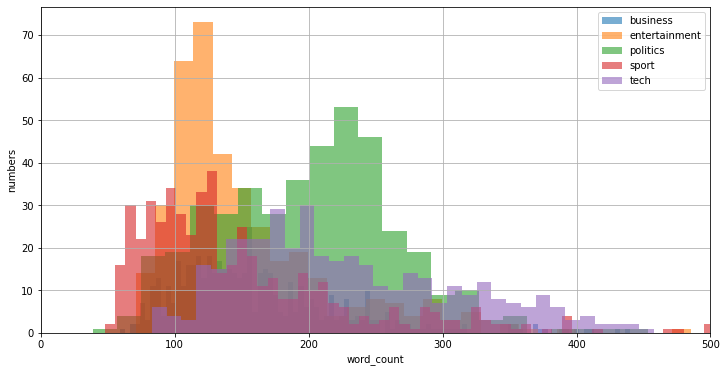

In [ ]:
# histogram of all topic's word_count
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc1_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

In [ ]:
# Average Word Length

In [ ]:
# creating 'avg_word' column
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))
bbc1['avg_word'] = bbc1['news'].apply(lambda x: avg_word(x))
print(bbc1.head())

                                                news  ...  avg_word
0  euros unit buyer face loan claim owners embatt...  ...  6.000000
1  ad sales boost warner profit quarterly profit ...  ...  6.300469
2  dollar gain greenspan speech dollar hit highes...  ...  6.096257
3  trade gap hit record gap export import hit all...  ...  6.220779
4  high fuel price hit ba profit british airways ...  ...  6.049505

[5 rows x 5 columns]


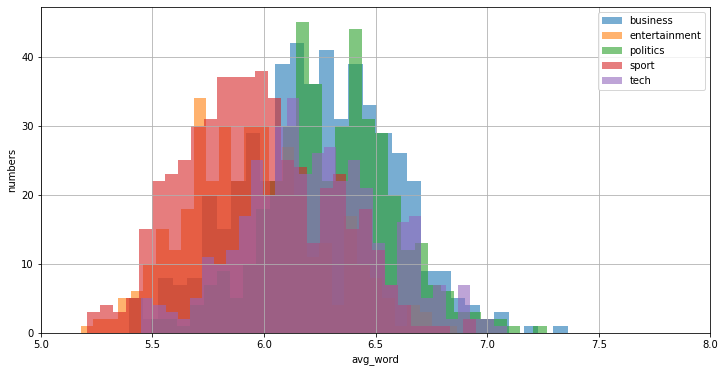

In [ ]:
# histogram of all topic's avg_word
bbc1_business = bbc1[bbc1['topics'] == 'business']
bbc1_entertainment = bbc1[bbc1['topics'] == 'entertainment']
bbc1_politics = bbc1[bbc1['topics'] == 'politics']
bbc1_sport = bbc1[bbc1['topics'] == 'sport']
bbc1_tech = bbc1[bbc1['topics'] == 'tech']

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 30
plt.hist(bbc1_business['avg_word'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc1_entertainment['avg_word'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc1_politics['avg_word'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc1_sport['avg_word'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc1_tech['avg_word'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('avg_word')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(5,8)
plt.grid()
plt.show()


# Model building

In [ ]:
# vectorization

In [ ]:
# using TF-IDF vectorizer 
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.05)
small_document_term_matrix = vectorizer.fit_transform(bbc1['news'])

In [ ]:
# sparse matrix size
small_document_term_matrix.shape

(2225, 526)


# Latent Dirichlet allocation (LDA)

In [ ]:
# LDA model
lda = LatentDirichletAllocation(n_components=5, max_iter=1000, random_state=0, n_jobs=-1)
lda.fit(small_document_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=1000,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# checking top 15 words for each of our LDA topics 
terms_lda = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
  terms_comp = zip(terms_lda, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
bn company firm bank market share price rise growth economy sales profit economic trade deal 

topic 1: 
rat england election radio pressure beat match victory minutes britain thing labour vote programme howard 

topic 2: 
win game play england club match champion cup team coach players injury world ireland wales 

topic 3: 
labour party blair government election minister brown people plan howard tax prime secretary public vote 

topic 4: 
film award music people star game best new tv phone include mobile technology software release 



In [ ]:
# creating function for wordcloud of LDA topics
def draw_word_cloud_lda(index):
  imp_words_topic=""
  comp=lda.components_[index]
  terms_comp = zip(terms_lda, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

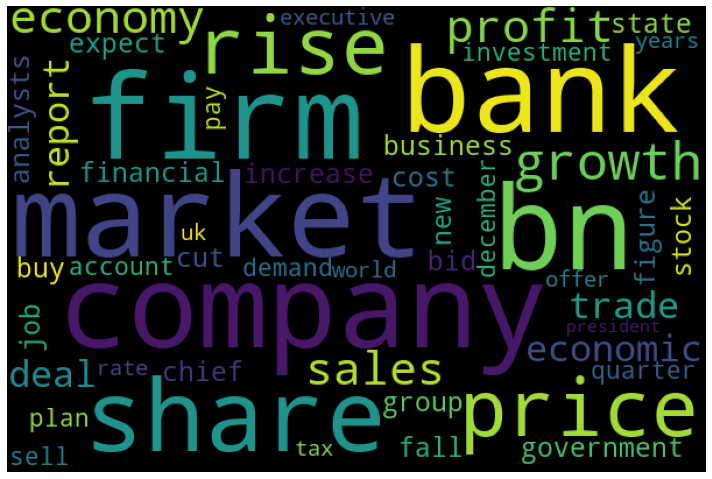

In [ ]:
# wordcloud of LDA topics
draw_word_cloud_lda(0)

In [ ]:
# we can classify this topic as 'business'

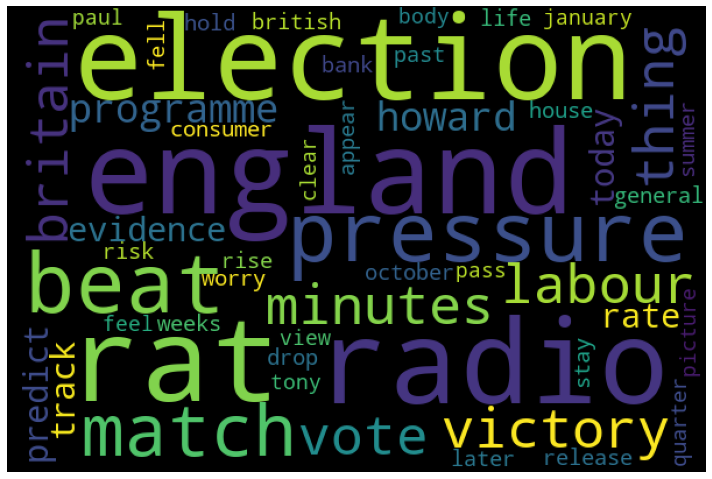

In [ ]:
draw_word_cloud_lda(1)

In [ ]:
# we cannot classify this topic as single toipcs. it seems mix of 'sport' and 'tech'

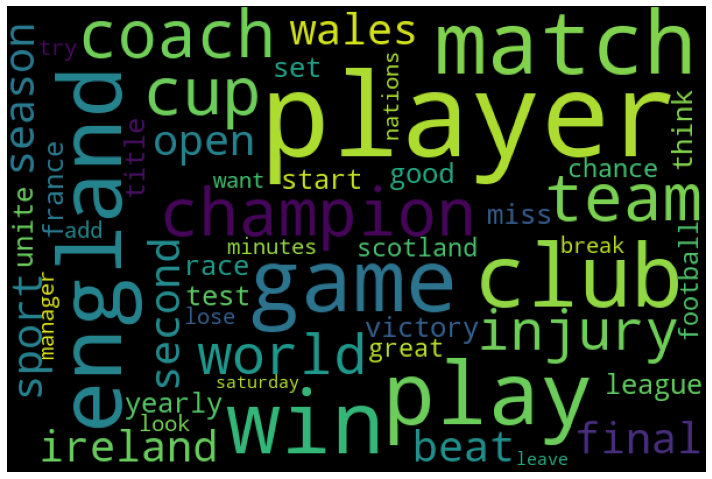

In [ ]:
draw_word_cloud_lda(2)

In [ ]:
# we can classify this topic as 'sport'

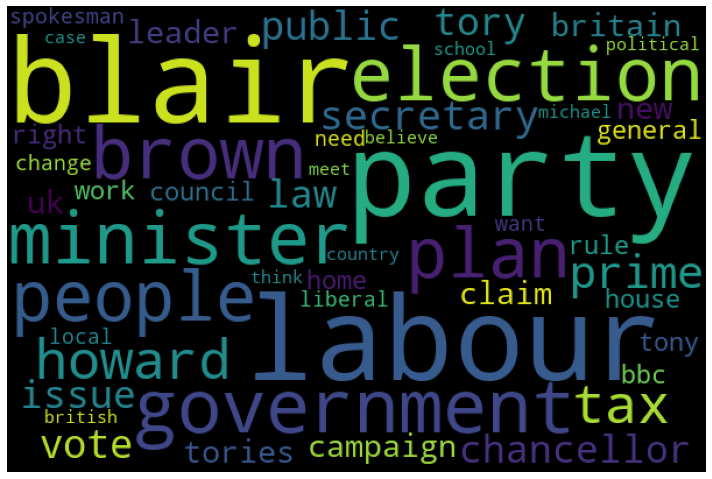

In [ ]:
draw_word_cloud_lda(3)

In [ ]:
# we can classify this topic as 'politics' topic

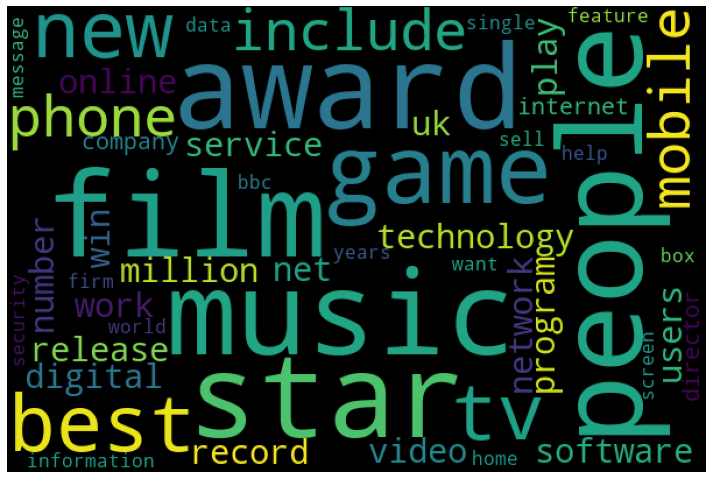

In [ ]:
draw_word_cloud_lda(4)

In [ ]:
# we cannot classify this as a single topic, it is mix topic

In [ ]:
# summary of LDA model

In [ ]:
# model able to correctly classify 3 topics i.e politics, business and sport
# for other two clusters it was unable to classify the clusters as entertainment and sports

# Latent Semantic Analysis (LSA)

In [ ]:
# LSA model
svd = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=1000, random_state=0)
svd.fit(small_document_term_matrix)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=1000,
             random_state=0, tol=0.0)

In [ ]:
# checking top 15 words for each of our LSA topics 
terms_lsa = vectorizer.get_feature_names()
for i, comp in enumerate(svd.components_):
  terms_comp = zip(terms_lsa, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
game film people win new play company bn world government firm uk work best want 

topic 1: 
film game win play award best star england match cup players champion beat team injury 

topic 2: 
film award best star music company bn firm director include sales tv million market share 

topic 3: 
film labour blair party election award brown best howard minister prime star tax tory government 

topic 4: 
phone people mobile users technology music software service digital program network net game tv internet 



In [ ]:
# creating function for wordcloud of LSA topics
def draw_word_cloud_lsa(index):
  imp_words_topic=""
  comp=svd.components_[index]
  terms_comp = zip(terms_lsa, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [ ]:
# wordcloud of LSA topics

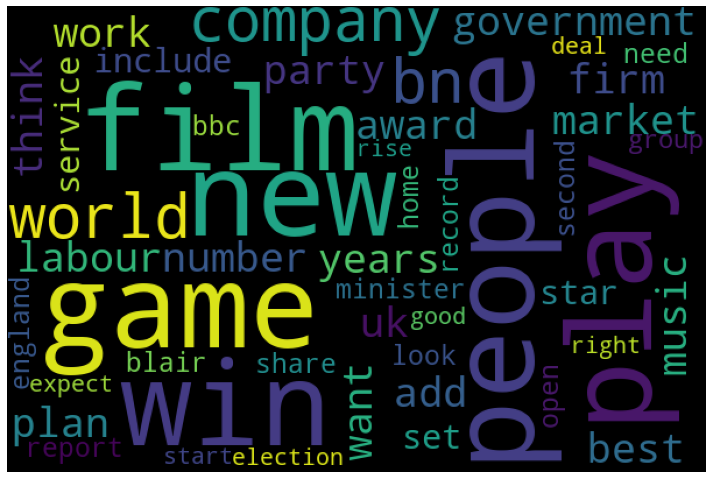

In [ ]:
draw_word_cloud_lsa(0)

In [ ]:
# predominantly the cluster is showing as 'entertainment' topic, but we can not surely classify this as 'entertainment' topic. It is a mix topic.

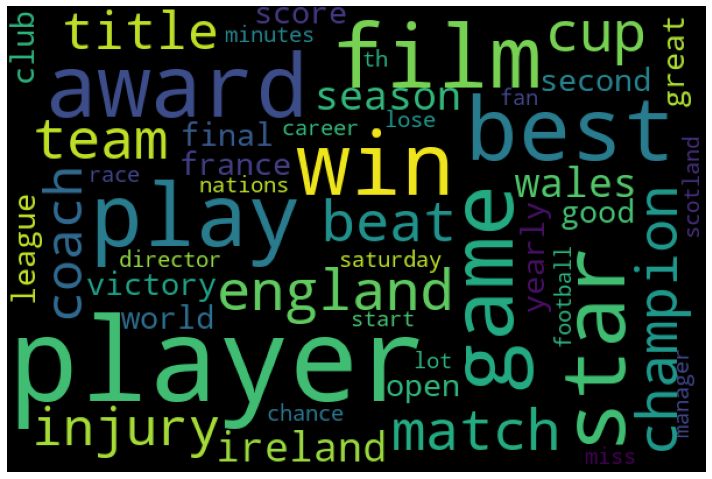

In [ ]:
draw_word_cloud_lsa(1)

In [ ]:
# we can classify this topic as 'sport'

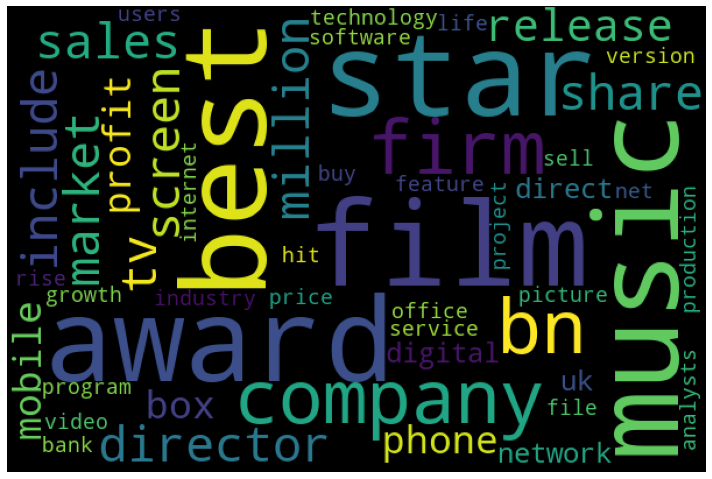

In [ ]:
draw_word_cloud_lsa(2)

In [ ]:
# we can classify this topic as 'entertainment'

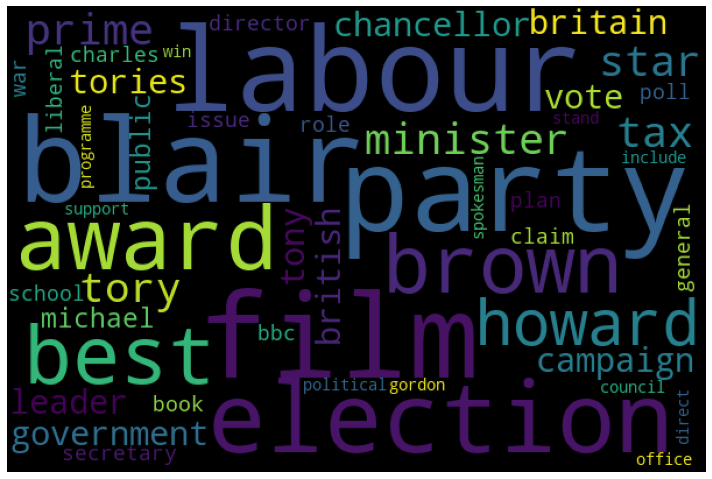

In [ ]:
draw_word_cloud_lsa(3)

In [ ]:
# we can classify this topic as 'politics'

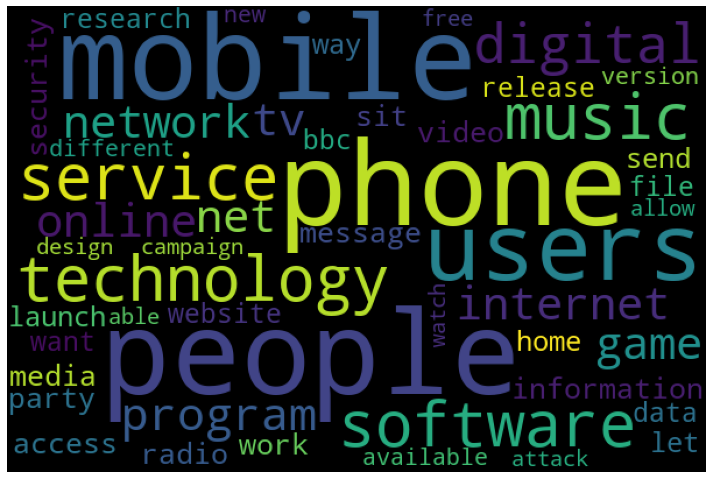

In [ ]:
draw_word_cloud_lsa(4)

In [ ]:
# we can classify this topic as 'tech'

In [ ]:
# summary of LSA model

In [ ]:
# model able to correctly classify 4 topics i.e sports, entertainment, politics and tech
# model was unable to classify the topic 'business' properly

# Non-negative matrix factorization (NMF)

In [ ]:
# NMF model
nmf = NMF(n_components=5, max_iter=1000)
nmf.fit(small_document_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=1000,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
# checking top 15 words for each of our NMF topics 
terms_nmf = vectorizer.get_feature_names()
for i, comp in enumerate(nmf.components_):
  terms_comp = zip(terms_nmf, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
  print("topic "+str(i)+": ")
  for t in sorted_words:
      print(t[0],end=" ")
  print("\n")

topic 0: 
bn company bank firm market rise share growth price sales economy profit economic trade deal 

topic 1: 
game win play england match cup players team champion wales club world coach ireland injury 

topic 2: 
film award best star director win include british screen box tv role direct release office 

topic 3: 
labour party blair election minister government brown tax howard prime tory plan chancellor campaign tories 

topic 4: 
people phone mobile music service technology users software digital net program network new tv firm 



In [ ]:
# creating function for wordcloud of NMF topics
def draw_word_cloud_nmf(index):
  imp_words_topic=""
  comp=nmf.components_[index]
  terms_comp = zip(terms_nmf, comp)
  sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()


In [ ]:
# wordcloud of NMF topics

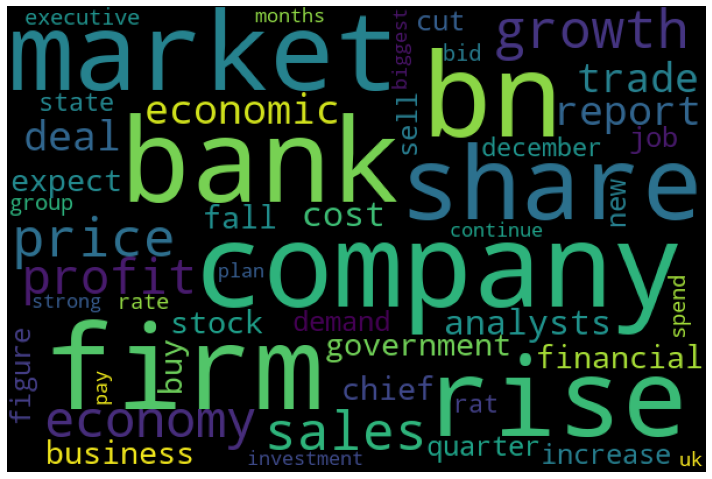

In [ ]:
draw_word_cloud_nmf(0)

In [ ]:
# we can classify this topic as 'business'

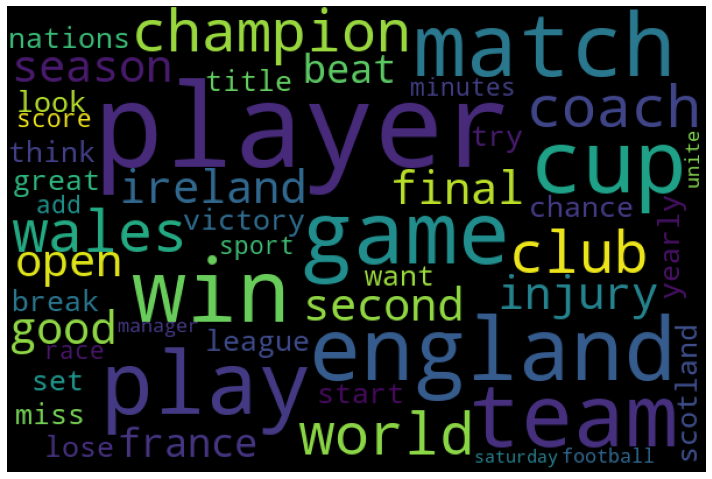

In [ ]:
draw_word_cloud_nmf(1)

In [ ]:
# we can classify this topic as 'sport'

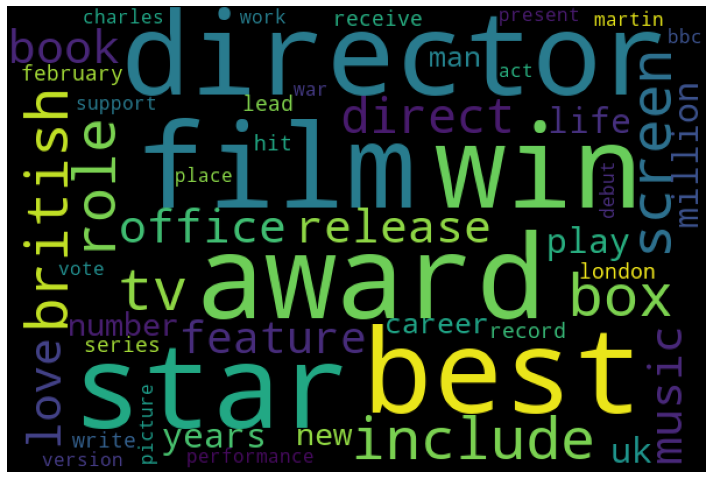

In [ ]:
draw_word_cloud_nmf(2)

In [ ]:
# we can classify this topic as 'entertainment'

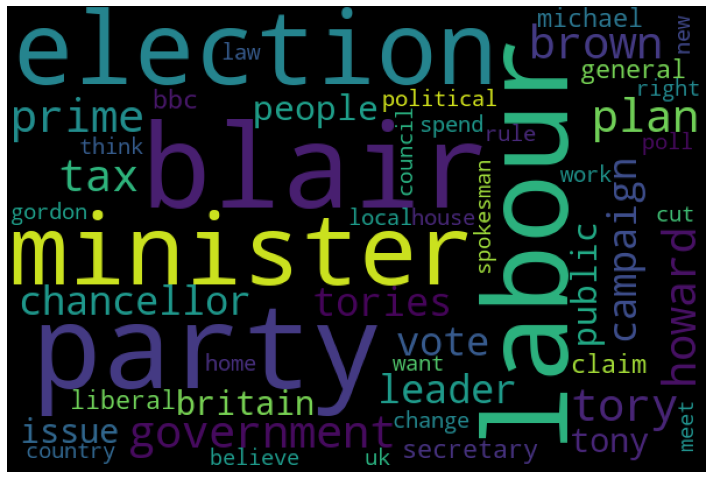

In [ ]:
draw_word_cloud_nmf(3)

In [ ]:
# we can classify this topic as 'politics'

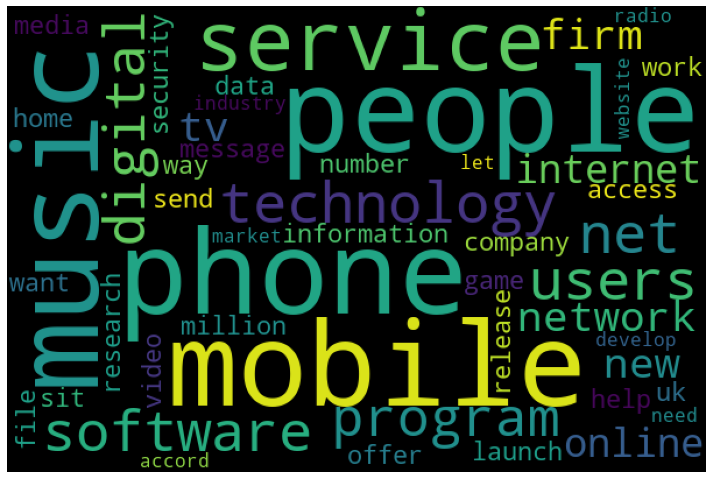

In [ ]:
draw_word_cloud_nmf(4)

In [ ]:
# we can classify this topic as 'tech'

In [ ]:
# summary of NMF model

In [ ]:
# model was able to correctly classify all the topics

In [ ]:

# Conclusion

    # NMF with TF-IDF vectorizer was the best model to identify the topics properly for our dataset
    # Scope of implementing LSA using genism library and neural network with word2vec in future

